::: {.content-hidden}
# Library Imports and Style Configuration
:::

In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import catppuccin
plt.style.use(catppuccin.PALETTE.latte.identifier)
%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# meta_df = pd.read_csv("/content/drive/MyDrive/Unified Mentor/Project 1/Coca-Cola_stock_info.csv")
# df = pd.read_csv("/content/drive/MyDrive/Unified Mentor/Project 1/Coca-Cola_stock_history.csv")

In [4]:
meta_df = pd.read_csv("Coca-Cola_stock_info.csv")

df = pd.read_csv("Coca-Cola_stock_history.csv")

# Exploratory Data Analysis

## Data Preview

In [29]:
pd.set_option("display.max_colwidth", 8)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-...,0.05...,0.05...,0.05...,0.05...,806400,0.0,0
1,1962-...,0.04...,0.04...,0.04...,0.04...,1574400,0.0,0
2,1962-...,0.04...,0.04...,0.04...,0.04...,844800,0.0,0
3,1962-...,0.04...,0.04...,0.04...,0.04...,1420800,0.0,0
4,1962-...,0.04...,0.04...,0.04...,0.04...,2035200,0.0,0


## Data Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15311 entries, 0 to 15310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          15311 non-null  object 
 1   Open          15311 non-null  float64
 2   High          15311 non-null  float64
 3   Low           15311 non-null  float64
 4   Close         15311 non-null  float64
 5   Volume        15311 non-null  int64  
 6   Dividends     15311 non-null  float64
 7   Stock Splits  15311 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 957.1+ KB


In [7]:
df["Date"] = pd.to_datetime(df["Date"], format="ISO8601", utc=True)

## Missing Values

In [8]:
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

# Coca-Cola Stock Price

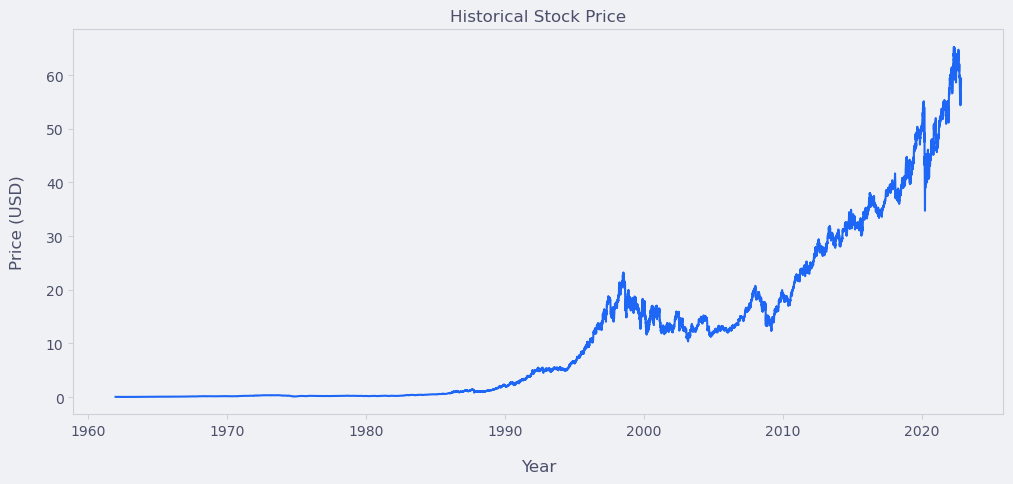

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["Close"])
plt.title("Historical Stock Price")
plt.xlabel("Year", fontsize=12, labelpad=15)
plt.ylabel("Price (USD)", fontsize=12, labelpad=15)
plt.show()

::: {.content-hidden}
# Preparation for LSTM ML Model
:::

::: {.content-hidden}
## Normalization
:::

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_closing_price = scaler.fit_transform(np.array(df["Close"]).reshape(-1, 1))

::: {.content-hidden}
## Train Test Split
:::

In [11]:
# Split the dataset into training and testing sets (80% for training, 20% for testing)
train_size = int(len(scaled_closing_price) * 0.8)
test_size = len(scaled_closing_price) - train_size

# Create training and testing datasets from the scaled closing prices
train_data, test_data = (
    scaled_closing_price[0:train_size, :],
    scaled_closing_price[train_size : len(scaled_closing_price), :1],
)


# Define a function to transform the time series data into sequences for supervised learning
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    # Loop over the dataset to create input-output pairs based on the time step
    for i in range(len(dataset) - time_step - 1):
        # Input sequence of length 'time_step'
        a = dataset[i : (i + time_step), 0]
        dataX.append(a)
        # Output is the value followming the input sequence
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


# Set the time step (number of previous time steps used to predict the next value)
time_step = 100

# Generate input-output pairs for both training and testing datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input data to fit the LSTM model: [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

::: {.content-hidden}
# Create the Stacked LSTM model
:::

::: {.content-hidden}
## LSTM model builder function
:::

In [12]:
import keras_tuner as kt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop


# Define the LSTM model builder function
def build_model(hp):
    model = Sequential()

    # Tune number of LSTM units
    hp_units = hp.Int("units", min_value=32, max_value=256, step=32)
    model.add(
        LSTM(units=hp_units, return_sequences=False, input_shape=(X_train.shape[1], 1))
    )

    # Tune dropout rate
    hp_dropout = hp.Float("dropout", min_value=0.0, max_value=0.3, step=0.3)
    model.add(Dropout(hp_dropout))

    # Output layer
    model.add(Dense(1))

    

    # Tune optimizer type and learning rate
    hp_optimizer = hp.Choice("optimizer", values=["adam", "rmsprop"])
    hp_learning_rate = hp.Float(
        "learning_rate", min_value=1e-5, max_value=1e-4, sampling="log"
    )

    if hp_optimizer == "adam":
        optimizer = Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

2025-06-15 22:33:04.552934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:33:04.556415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 22:33:04.570905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750006984.593817   15372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750006984.599988   15372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750006984.617206   15372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

::: {.content-hidden}
## Hyperparameter Search Setup

In [13]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=26,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="stock_price_forecasting"
)

Reloading Tuner from lstm_tuning/stock_price_forecasting/tuner0.json


:::

::: {.content-hidden}
## Tuning Model
:::

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

tuner.search(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Tuned Parameters of the Best-Performing Model

In [15]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_hyperparams.get('units')}")
print(f"Dropout: {best_hyperparams.get('dropout')}")
print(f"Optimizer: {best_hyperparams.get('optimizer')}")
print(f"Learning Rate: {best_hyperparams.get('learning_rate')}")

Best Hyperparameters:
Units: 224
Dropout: 0.02
Optimizer: adam
Learning Rate: 0.0005565455205477173


2025-06-15 22:33:06.903194: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/nipuran/miniforge3/envs/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/nipuran/miniforge3/envs/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


::: {.content-hidden}

In [16]:
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

380/380 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


In [17]:
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE, MAE, MAPE using sklearn
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step
RMSE : 0.62
MAE  : 0.40
MAPE : 1.02%


:::

# Model Acuracy Metrics

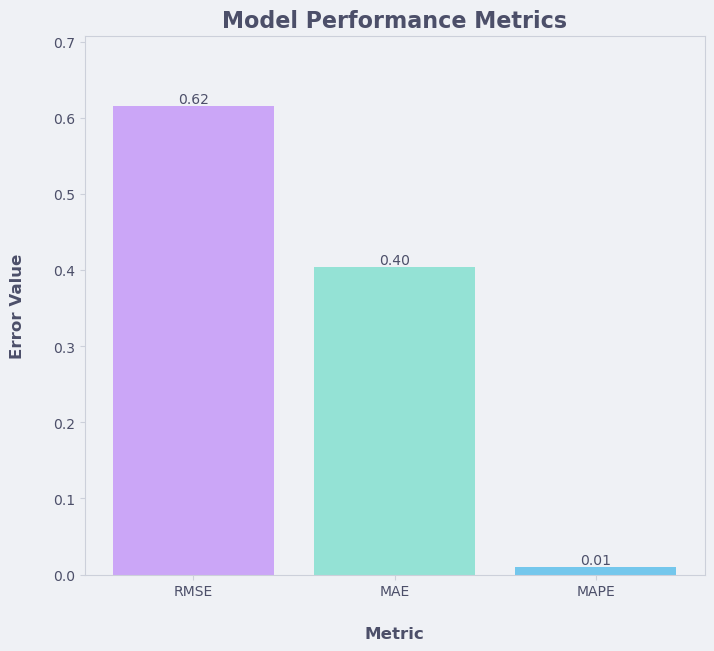

In [18]:
# Data
metrics = ["RMSE", "MAE", "MAPE"]
values = [rmse, mae, mape]

# Create a figure and axes
plt.figure(figsize=(8, 7))
bars = plt.bar(metrics, values, color=["#cba6f7", "#94e2d5", "#74c7ec"])

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.2f}",
        va="bottom",
        ha="center",
    )

# Add a title and labels
plt.title("Model Performance Metrics", fontweight="bold", fontsize=16)
plt.ylabel("Error Value", fontsize=12, labelpad=20, fontweight="bold")
plt.xlabel("Metric", fontsize=12, labelpad=20, fontweight="bold")

plt.ylim(0, max(values) * 1.15)

# Display the plot
plt.show()

# Predicted vs. Acutal Data

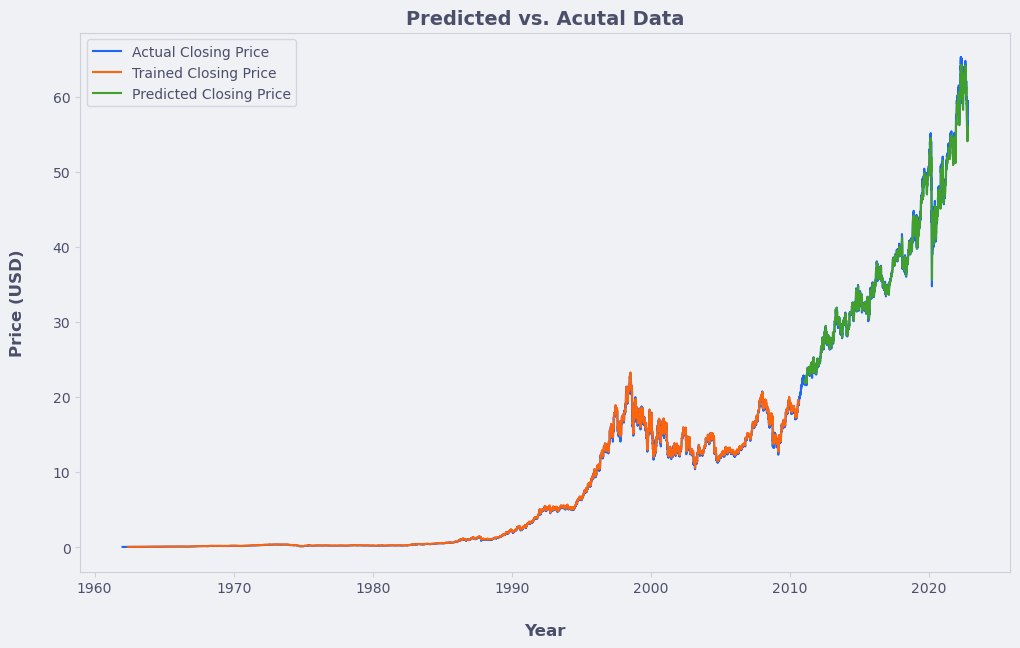

In [19]:
# shift train predictions for plotting
look_back = 100
trainPredictPlot = np.empty_like(scaled_closing_price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(train_predict) + look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_closing_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(train_predict) + (look_back * 2) + 1 : len(scaled_closing_price) - 1, :
] = test_predict
# plot baseline and predictions
plt.figure(figsize=(12, 7))
plt.plot(
    df["Date"],
    scaler.inverse_transform(scaled_closing_price),
    label="Actual Closing Price",
)
plt.plot(df["Date"], trainPredictPlot, label="Trained Closing Price")
plt.plot(df["Date"], testPredictPlot, label="Predicted Closing Price")
plt.title("Predicted vs. Acutal Data", fontweight="bold", fontsize=14)
plt.xlabel("Year", fontsize=12, labelpad=20, fontweight="bold")
plt.ylabel("Price (USD)", fontsize=12, labelpad=20, fontweight="bold")
plt.legend()
plt.show()

In [20]:
x_input = test_data[2963:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [21]:
# demonstrate forecasting for next 30 days

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)

        x_input = x_input.reshape((1, n_steps, 1))

        yhat = best_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = best_model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Price Forecast for the Next 30 Days

In [22]:
actual_dates = df["Date"][15211:]
forecasted_dates = pd.date_range(start="2022-10-27", periods=30, freq="D")

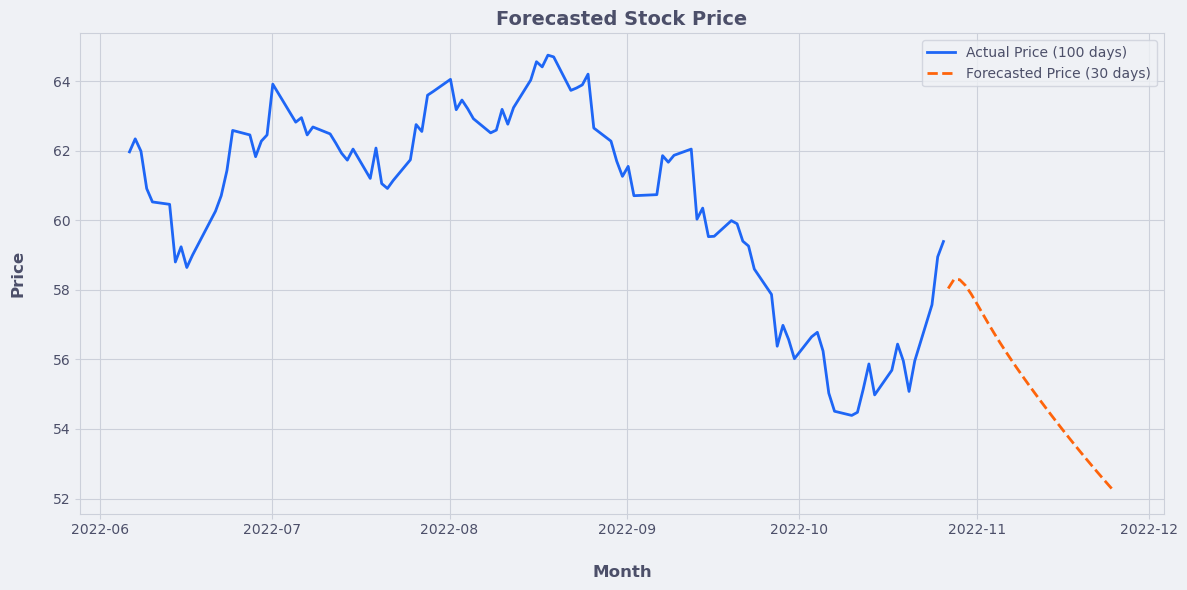

In [23]:
# Plotting actual prices
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, scaler.inverse_transform(scaled_closing_price[15211:]), label="Actual Price (100 days)", linewidth=2)

# Plotting forcasting prices
plt.plot(forecasted_dates, scaler.inverse_transform(lst_output), label="Forecasted Price (30 days)", linestyle='--', linewidth=2)

plt.title("Forecasted Stock Price", fontweight='bold', fontsize=14)
plt.xlabel("Month", fontweight='bold', fontsize=12,  labelpad=20)
plt.ylabel("Price", fontweight='bold', fontsize=12,  labelpad=20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()